# HW4.

by Handan Cetin | USCID: 6074572947 | github: handancetin

In [25]:
import os
import csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample # for bootstrapping
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
import random
random.seed(1234) # for reproducibility

import warnings
warnings.filterwarnings('ignore') # for plots

## 1. Feature Creation/Extraction
Cells in this section have the codes from the HW3 (without outputs) with a modification.

Lines 10 and 15 are updated to search for 'dataset#.csv' instead of 'dataset#' 

This was wrongly done in HW3 as the datasets numbered 10+ were mistakenly put into testing set.

In [26]:
filepath = '../data/AReM/'
trainFiles = []
testFiles  = []
fileCounter = 0
# Loop through each file in the folders
for root, dir, file in os.walk(filepath):
    for f in file:       
        fpof = os.path.join(root, f)
        if 'bending' in fpof:
            if ('dataset1.csv' in fpof) or ('dataset2.csv' in fpof):
                testFiles.append(fpof)
            else:
                trainFiles.append(fpof)
        else:
            if ('dataset1.csv' in fpof) or ('dataset2.csv' in fpof) or ('dataset3.csv' in fpof):
                testFiles.append(fpof)
            else:
                trainFiles.append(fpof)
        fileCounter = fileCounter + 1

In [27]:
trainingSet = []
testingSet = []
for exp in ['train', 'test']:
    if exp == 'train' :  
        files = trainFiles
    else:                
        files = testFiles

    values  = []
    folderName = []
    
    # Read each file and keep the folder name
    for f in files:
        filename_components = os.path.dirname(f).split("/")
        folderName.append(filename_components[-1])

        # bending2/dataset4 is not comma-seperated, so this part is required
        separator = csv.Sniffer().sniff(open(f).read()).delimiter
        if separator == ",":
            fc = pd.read_csv(f, skiprows=5, header=None, on_bad_lines='skip') 
        else:
            fc = pd.read_csv(f, skiprows=5, sep="\\s+", header=None, on_bad_lines='skip')

        fc.columns = ['time','avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
        values.append(fc.describe().drop('count').drop(columns='time').T.values.flatten())
            
    # Generate statistics
    df = pd.DataFrame(values)
    statNames = []
    for s in range(1, 7):
        for stat in ['mean', 'std', 'min', '1st quart', 'median', '3rd quart', 'max']:
            statNames.append(f'{stat} ({s})')
    df.columns = statNames

    # add activity column
    df['activity'] = pd.Series(folderName)

    # Save the dataframes
    if exp == 'train' :  
        trainingSet = df
    else:                
        testingSet  = df
        
trainingSet['isTraining'] = True
testingSet['isTraining'] = False

allData = pd.concat([trainingSet, testingSet])

In [28]:
bootstrappedSet = []
for sample in range(1000): # random sampling of 1000 points
    resampled = resample(allData.iloc[:, :-2]) # Bootstrapping excluding the activity and isTraining columns
    bootstrappedSet.append(resampled.apply(lambda col: np.std(col)))

bootstrappedSet = pd.DataFrame(bootstrappedSet)
bootstrappedSet.columns = list(allData.columns[:-2])
confInterval = bootstrappedSet.apply(lambda col : (np.percentile(col, 5), np.percentile(col, 95)), axis=0).apply(np.around, args=(2,)).T
confInterval.columns = ['lower bound', 'higher bound']
confInterval['CI range'] = confInterval['higher bound']-confInterval['lower bound']

I chose the features with relatively clearer seperation during HW3, I will continue using these features in this HW4.
* max
* median
* 3rd quartile


## 2. Binary and Multiclass Classification

### 2.(a) Binary Classification Using Logistic Regression

### 2.(a)i. Assume that you want to use the training set to classify 
bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to 
distinguish bending vs. other activities. (See p. 129 of the textbook)

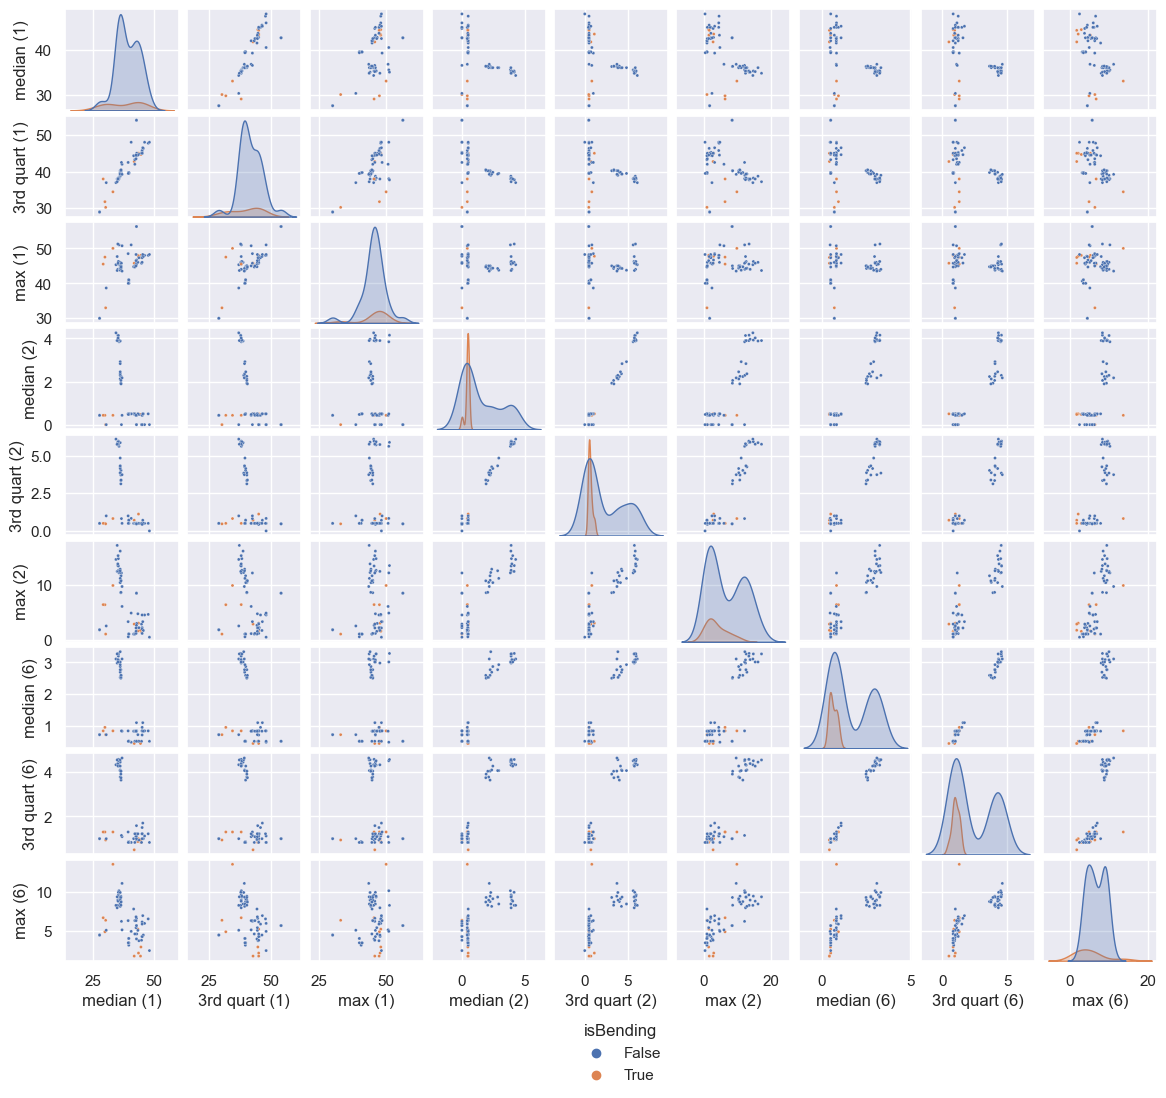

In [29]:
selectedFeaturesCols = trainingSet.filter(regex='max|median|3rd quart|activity').filter(regex='(1)|(2)|(6)|activity')
selectedFeaturesCols['isBending'] = selectedFeaturesCols['activity'].map(lambda x: True if 'bending' in x else False)

p = sns.pairplot(data = selectedFeaturesCols, kind = 'scatter', hue='isBending', grid_kws={'despine' : False}, plot_kws={"s": 5})
p.fig.set_size_inches(12,10)
sns.move_legend(p, "lower center", bbox_to_anchor=(0.5, -0.1))

### 2.(a)ii. Break each time series in your training set into two (approximately) equal length time series. 
Now instead of 6 time series for each of the training
instances, you have 12 time series for each training instance. Repeat the
experiment in 2(a)i, i.e depict scatter plots of the features extracted from both
parts of the time series 1,2, and 6. Do you see any considerable difference in
the results with those of 2(a)i?

In [30]:
# Reading the files again with equal length subset
trainingSet2 = []
testingSet2 = []
for exp in ['train', 'test']:
    if exp == 'train' :  
        files = trainFiles
    else:                
        files = testFiles

    values  = []
    folderName = []
    
    # Read each file and keep the folder name
    for f in files:
        filename_components = os.path.dirname(f).split("/")
        folderName.append(filename_components[-1])

        # bending2/dataset4 is not comma-seperated, so this part is required
        separator = csv.Sniffer().sniff(open(f).read()).delimiter
        if separator == ",":
            fc = pd.read_csv(f, skiprows=5, header=None, on_bad_lines='skip') 
        else:
            fc = pd.read_csv(f, skiprows=5, sep="\\s+", header=None, on_bad_lines='skip')

        fc.columns = ['time','avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

        # Break the time series into two equal lengths   
        subsetLength = int(fc.shape[0] / 2) 
        description = []
        for i in range(2):
            curStart = i * subsetLength
            curEnd  = min((i + 1) * subsetLength, fc.shape[0])
            curSubset = fc[curStart : curEnd] 
            curDescribe = curSubset.describe().drop('count').drop(columns='time').T
            description.append(curDescribe.values.flatten())
 
        values.append(np.concatenate(description))
            
        # Generate statistics
        df = pd.DataFrame(values)
        statNames = []
        for s in range(1, 13):
            for stat in ['mean', 'std', 'min', '1st quart', 'median', '3rd quart', 'max']:
                statNames.append(f'{stat} ({s})')
        df.columns = statNames

    # Add activity column
    df['activity'] = pd.Series(folderName)

    # Save the dataframes
    if exp == 'train' :  
        trainingSet2 = df
    else:                
        testingSet2  = df
        
trainingSet2['isTraining'] = True
testingSet2['isTraining'] = False

allData2 = pd.concat([trainingSet2, testingSet2])

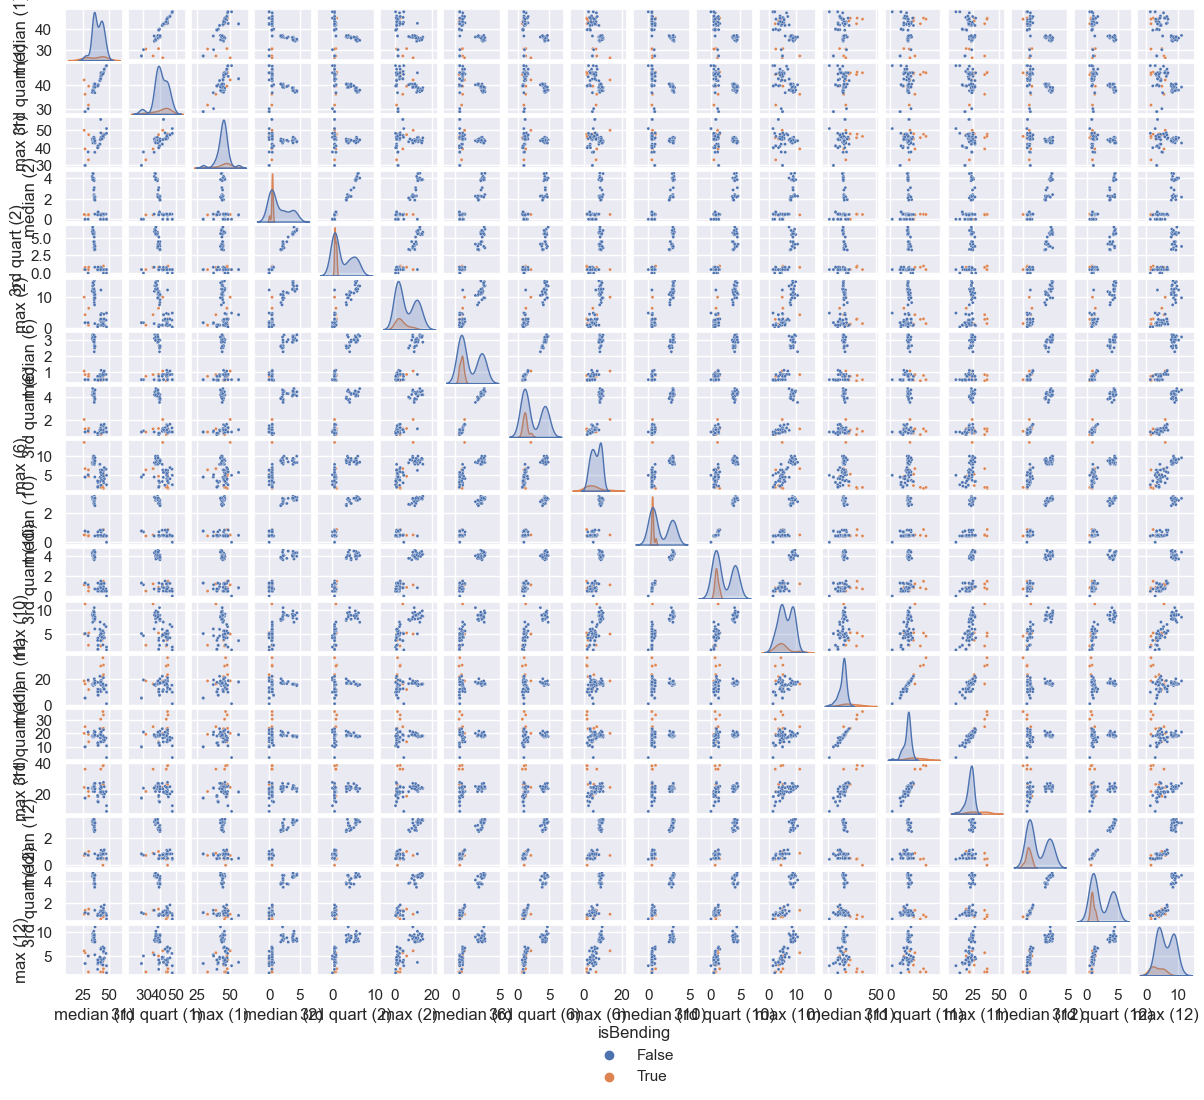

In [31]:
selectedFeaturesCols2 = trainingSet2.filter(regex='max|median|3rd quart|activity').filter(regex='(1)|(2)|(6)|activity')
selectedFeaturesCols2['isBending'] = selectedFeaturesCols2['activity'].map(lambda x: True if 'bending' in x else False)

p = sns.pairplot(data = selectedFeaturesCols2, kind = 'scatter', hue='isBending', grid_kws={'despine' : False}, plot_kws={"s": 5})
p.fig.set_size_inches(12,10)
sns.move_legend(p, "lower center", bbox_to_anchor=(0.5, -0.1))
sns.set(font_scale=0.5)

In [32]:
sns.set(font_scale=1) # set to normal

Just looking at the plots, there is no significant/considerable difference between the results.

### 2.(a)iii. Break each time series in your training set into l ∈ {1,2,...,20} 
time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. 

Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features. Alternatively, you can use backward selection using sklearn.feature selection or glm in R. 

Use 5-fold cross-validation to determine the best value of the pair (l,p), where p is the number of features used in recursive feature elimination.

Explain what the right way and the wrong way are to perform cross-validation in this problem.7 Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.

In [33]:
# Since we are repeatedly doing the same things, it is better to define functions:
def readAndBreakData(nSubsets = 1):
    trainingSet = []
    testingSet = []
    for exp in ['train', 'test']:
        if exp == 'train' :  
            files = trainFiles
        else:                
            files = testFiles

        values  = []
        folderName = []
        
        # Read each file and keep the folder name
        for f in files:
            filename_components = os.path.dirname(f).split("/")
            folderName.append(filename_components[-1])

            # bending2/dataset4 is not comma-seperated, so this part is required
            separator = csv.Sniffer().sniff(open(f).read()).delimiter
            if separator == ",":
                fc = pd.read_csv(f, skiprows=5, header=None, on_bad_lines='skip') 
            else:
                fc = pd.read_csv(f, skiprows=5, sep="\\s+", header=None, on_bad_lines='skip')

            fc.columns = ['time','avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

            # Break the time series data by lengths using nSubset 
            subsetLength = int(fc.shape[0] / nSubsets) 
            description = []
            for i in range(nSubsets):
                curStart = i * subsetLength
                curEnd  = min((i + 1) * subsetLength, fc.shape[0])
                curSubset = fc[curStart : curEnd] 
                curDescribe = curSubset.describe().drop('count').drop(columns='time').T
                description.append(curDescribe.values.flatten())
    
            values.append(np.concatenate(description))
                
            # Generate statistics
            df = pd.DataFrame(values)
            statNames = []
            for s in range(1, (6*nSubsets)+1):
                for stat in ['mean', 'std', 'min', '1st quart', 'median', '3rd quart', 'max']:
                    statNames.append(f'{stat} ({s})')
            df.columns = statNames

        # Add activity column
        df['activity'] = pd.Series(folderName)

        # Save the dataframes
        if exp == 'train' :  
            trainingSet = df
        else:                
            testingSet  = df
        
    return trainingSet, testingSet

def chooseStats(stats, range_end):
    features = []
    for i in range(1, range_end):
        for stat in stats:
            features.append(f'{stat}{i}')
    return features

def oversampleData(df): 
    labelFalse = df.loc[df['activity'] == False].shape[0]
    labelTrue = df.loc[df['activity'] == True].shape[0]
    if labelFalse > labelTrue:
        minorLabel = True
        majorLabel = False
    else:
        minorLabel = False
        majorLabel = True
    minorSubset = df[df['activity'] == minorLabel]
    majorSubset = df[df['activity'] == majorLabel]
    minorSubset = resample(minorSubset, replace = True, random_state = 60, n_samples = max(labelFalse, labelTrue))
    oversampledData = pd.concat([majorSubset, minorSubset])
    return oversampledData

def convertActivityToBooleanWrtBending(df): 
    tmp = df['activity']
    df.loc[tmp.isin(['bending1', 'bending2']), 'activity'] = True
    df.loc[tmp != True, 'activity'] = False
    return df

def generateTargets(df, isBinary = True): 
    subsetFeatures = df.iloc[:, :-1]
    if isBinary:
        subsetTarget = df.iloc[:, -1].astype(int) # to binary
    else:
        subsetTarget = df.iloc[:, -1]
    return subsetFeatures, subsetTarget

def performLogisticRegression(lVal, nSplits, performOversample = False, penalty = 'none'): 
    print(f'Performing logistic regression for l = {lVal}..', end =' ')
    trainingSet, testingSet = readAndBreakData(nSubsets = lVal)
    trainingSet = convertActivityToBooleanWrtBending(pd.DataFrame(trainingSet))
    testingSet  = convertActivityToBooleanWrtBending(pd.DataFrame(testingSet))
    
    if performOversample:
        print('oversampling..', end =' ')
        trainingSet = oversampleData(trainingSet)
    
    trainFeatures, trainTarget = generateTargets(trainingSet, isBinary = True)
    testFeatures, testTarget = generateTargets(testingSet, isBinary = True)

    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'
    validator = StratifiedKFold(n_splits = nSplits, shuffle = True)
    LRModel = LogisticRegression(penalty = penalty, solver = solver)
    selector = RFECV(estimator = LRModel, cv = validator, scoring = 'accuracy')
    selector.fit(trainFeatures, trainTarget)
    selector.predict(testFeatures)
    print(f'done.')
    return LRModel, selector


In [34]:
pairedScores = {'Pair (l, p)': [],
                'Score': [] }
for lVal in range(1, 21):
    LRModel, selector = performLogisticRegression(lVal, nSplits = 5, performOversample = False)
    nFeatures = selector.n_features_
    testScore = selector.cv_results_['mean_test_score'].max()
    pairedScores['Pair (l, p)'].append((lVal, nFeatures))
    pairedScores['Score'].append(round(testScore, 4))

pairedScores = pd.DataFrame(pairedScores)
pairedScores

Performing logistic regression for l = 1.. done.
Performing logistic regression for l = 2.. done.
Performing logistic regression for l = 3.. done.
Performing logistic regression for l = 4.. done.
Performing logistic regression for l = 5.. done.
Performing logistic regression for l = 6.. done.
Performing logistic regression for l = 7.. done.
Performing logistic regression for l = 8.. done.
Performing logistic regression for l = 9.. done.
Performing logistic regression for l = 10.. done.
Performing logistic regression for l = 11.. done.
Performing logistic regression for l = 12.. done.
Performing logistic regression for l = 13.. done.
Performing logistic regression for l = 14.. done.
Performing logistic regression for l = 15.. done.
Performing logistic regression for l = 16.. done.
Performing logistic regression for l = 17.. done.
Performing logistic regression for l = 18.. done.
Performing logistic regression for l = 19.. done.
Performing logistic regression for l = 20.. done.


,"Pair (l, p)",Score
0,"(1, 4)",0.9714
1,"(2, 6)",0.9714
2,"(3, 9)",0.9846
3,"(4, 23)",0.9857
4,"(5, 3)",0.9857
5,"(6, 35)",0.9846
6,"(7, 12)",0.9571
7,"(8, 21)",0.9857
8,"(9, 30)",0.9857
9,"(10, 16)",0.9703



Looking at the output, there are multiple best values of pairs (l,p) with the highest score: I would report (1, 5) as the best pair if an answer is required as it is the first one. However we need to check various performance metrics before making a concrete decision.  The purpose of cross-validation is to assess the performance of a model. There are multiple methods such as k-fold cross-validation, stratified k-fold cross-validation, leave-one-out cross-validation. The correct way to perform cross-validation would be implementing the recursive feature elimination (RFE) within each fold of the cross-validation process. This way, we can evaluate the performance of the model after RFE. The wrong way would be performing RFE on the entire dataset before cross-validation.

> NOTE: Turns out, fixing random.seed() does not make the regression analyses reproducible (I am now realizing the additional argument for this function specifically). In the previous simulation, there was multiple score=1 results and (1,5) was one of them. Since I don't have enough time to re-do (sorry, I had to submit the last minute), I have to submit like this. Hope you can understand. 


### 2.(a)iv. Report the confusion matrix and show the ROC and AUC for your classifier
on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

In [35]:
# The first paor (1, 5) is chosen, so L is set to 1
chosenL = 1
colNames = []
for i in range(1, (6*chosenL)+1):
    for stat in ['mean', 'std', 'min', '1st quart', 'median', '3rd quart', 'max']:
        colNames.append(f'{stat} ({i})')
classifier, selector = performLogisticRegression(chosenL, 5)

selectedFeatures = []
for i, feature in enumerate(colNames):
    if selector.support_[i]:
        selectedFeatures.append(feature)
        
# Set the datatables
trainingSet, testingSet = readAndBreakData()
trainingSet = convertActivityToBooleanWrtBending(pd.DataFrame(trainingSet))
testingSet  = convertActivityToBooleanWrtBending(pd.DataFrame(testingSet))
trainFeatures, trainTarget = generateTargets(trainingSet, isBinary = True)
testFeatures, testTarget = generateTargets(testingSet, isBinary = True)
trainTarget = trainTarget.astype('int')
testTarget = testTarget.astype('int')

# Get the subset of selection
selectedTrainFeatures = trainFeatures.loc[:, selectedFeatures]

# Fit Logit
constant = sm.add_constant(selectedTrainFeatures.to_numpy(dtype = float))
model = sm.Logit(trainTarget, constant)
summary = model.fit(method = 'bfgs').summary()

# Summary table
print(summary)

Performing logistic regression for l = 1.. done.
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
                           Logit Regression Results                           
Dep. Variable:               activity   No. Observations:                   69
Model:                          Logit   Df Residuals:                       62
Method:                           MLE   Df Model:                            6
Date:                Mon, 16 Oct 2023   Pseudo R-squ.:                   1.000
Time:                        23:23:38   Log-Likelihood:            -8.8338e-06
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 9.588e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

In [36]:
def performROC(trainFeatures, trainTarget, selectedFeatures, isTest = False):
    if not isTest:
        classifier.fit(trainFeatures.loc[:, selectedFeatures], trainTarget)
    predictY = classifier.predict(trainFeatures.loc[:, selectedFeatures])
    
    predictedTargetProba = classifier.predict_proba(trainFeatures.loc[:, selectedFeatures])
    trueTarget = trainTarget.to_numpy(dtype=float)
    predictedTarget = predictY.round()
    confustionMatrix = confusion_matrix(trueTarget, predictedTarget)
    print('Matrix:')
    print(confustionMatrix)

    fig, axes = plt.subplots(figsize = (6, 5))
    for i, clss in enumerate(classifier.classes_):
        curPredictedTarget = predictedTargetProba[:, i]
        fpr, tpr, thresholds = roc_curve(trueTarget, curPredictedTarget, pos_label = clss)
        rocArea = auc(fpr, tpr)
        axes.plot(fpr, tpr, label=f'class:{clss}, ROC: {round(rocArea, 4)}') 
    axes.plot([0, 1], [0, 1], "--", label='x = y')
    axes.set_xlabel("false positive rate")
    axes.set_ylabel("true positive rate")
    axes.legend()
    plt.show()

The confusion matrix and the ROC curve for the training data:
Matrix:
[[60  0]
 [ 0  9]]


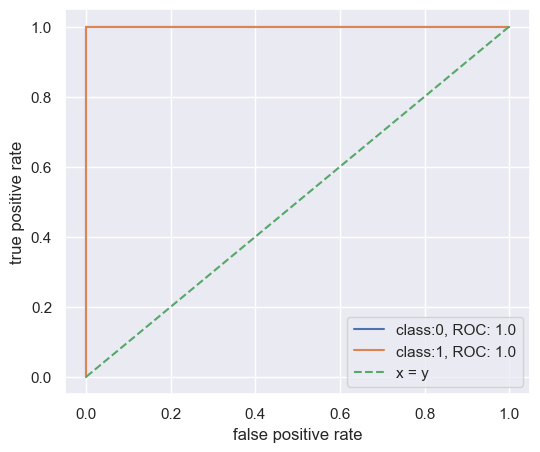

In [37]:
print('The confusion matrix and the ROC curve for the training data:')
performROC(trainFeatures, trainTarget, selectedFeatures)

### 2.(a)v. Test the classifier on the test set. 
Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

The confusion matrix and the ROC curve for the test data:
Matrix:
[[15  0]
 [ 0  4]]


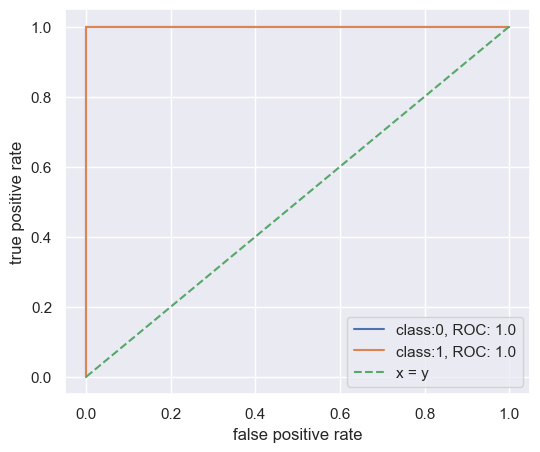

In [38]:
print('The confusion matrix and the ROC curve for the test data:')
performROC(testFeatures, testTarget, selectedFeatures)

### 2.(a)vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

As it can be seen from the summary table above, there is complete separation, i.e. the selected variables perfectly separates the two classes. This means that the outcome can be predicted with 100% accuracy, which is not realistic. When there is complete seperation, the likelihood becomes infinite, thus MLE does not exist, leading to computational problems and making it impossible to find the optimal parameter estimates. Thus, the parameters cannot be determined based on the data, they are unidentified.

### 2.(a)vii. From the confusion matrices you obtained, do you see imbalanced classes?
If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model. 

In [39]:
# The answer is YES. So, oversampleData is set to TRUE.
pairedScores = {'Pair (l, p)': [],
                'Score': [] }
for lVal in range(1, 21):
    LRModel, selector = performLogisticRegression(lVal, nSplits = 5, performOversample = True)
    nFeatures = selector.n_features_
    testScore = selector.cv_results_['mean_test_score'].max()
    pairedScores['Pair (l, p)'].append((lVal, nFeatures))
    pairedScores['Score'].append(round(testScore, 4))

pairedScores = pd.DataFrame(pairedScores)
pairedScores

Performing logistic regression for l = 1.. oversampling.. done.
Performing logistic regression for l = 2.. oversampling.. done.
Performing logistic regression for l = 3.. oversampling.. done.
Performing logistic regression for l = 4.. oversampling.. done.
Performing logistic regression for l = 5.. oversampling.. done.
Performing logistic regression for l = 6.. oversampling.. done.
Performing logistic regression for l = 7.. oversampling.. done.
Performing logistic regression for l = 8.. oversampling.. done.
Performing logistic regression for l = 9.. oversampling.. done.
Performing logistic regression for l = 10.. oversampling.. done.
Performing logistic regression for l = 11.. oversampling.. done.
Performing logistic regression for l = 12.. oversampling.. done.
Performing logistic regression for l = 13.. oversampling.. done.
Performing logistic regression for l = 14.. oversampling.. done.
Performing logistic regression for l = 15.. oversampling.. done.
Performing logistic regression for

,"Pair (l, p)",Score
0,"(1, 4)",1.0000
1,"(2, 5)",0.9917
2,"(3, 4)",1.0000
3,"(4, 3)",0.9917
4,"(5, 3)",0.9917
5,"(6, 3)",0.9917
6,"(7, 3)",0.9917
7,"(8, 3)",1.0000
8,"(9, 3)",1.0000
9,"(10, 5)",0.9917


Again, we can use the first pair (1, 4) as its score is maximum.

Performing logistic regression for l = 1.. oversampling.. done.
The confusion matrix and the ROC curve for the training data:
Matrix:
[[60  0]
 [ 0  9]]


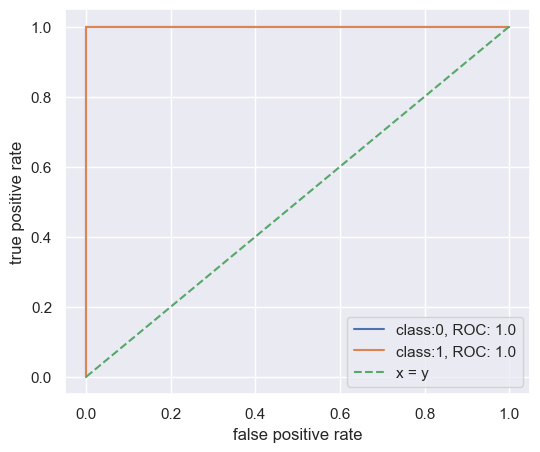

In [40]:
# The first paor (1, 8) is chosen, so L is set to 1
chosenL = 1
colNames = []
for i in range(1, (6*chosenL)+1):
    for stat in ['mean', 'std', 'min', '1st quart', 'median', '3rd quart', 'max']:
        colNames.append(f'{stat} ({i})')
classifier, selector = performLogisticRegression(chosenL, 5, performOversample = True)

selectedFeatures = []
for i, feature in enumerate(colNames):
    if selector.support_[i]:
        selectedFeatures.append(feature)
        
# Set the datatables
trainingSet, testingSet = readAndBreakData()
trainingSet = convertActivityToBooleanWrtBending(pd.DataFrame(trainingSet))
testingSet  = convertActivityToBooleanWrtBending(pd.DataFrame(testingSet))
trainFeatures, trainTarget = generateTargets(trainingSet, isBinary = True)
testFeatures, testTarget = generateTargets(testingSet, isBinary = True)

print('The confusion matrix and the ROC curve for the training data:')
performROC(trainFeatures, trainTarget, selectedFeatures)

The confusion matrix and the ROC curve for the test data:
Matrix:
[[15  0]
 [ 0  4]]


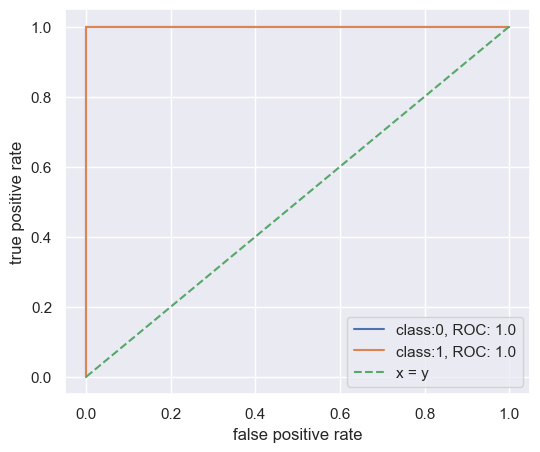

In [41]:

print('The confusion matrix and the ROC curve for the test data:')
performROC(testFeatures, testTarget, selectedFeatures)

### 2.(b) Binary Classification Using L1-penalized logistic regression

#### 2.(b)i. Repeat 2(a)iii using L1-penalized logistic regression

i.e. instead of using p-values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.

In [42]:
# function for specific classifier using kwargs
maxAccuracy = 0 # GLOBAL
bestL = 1
def performThisRegression(classifier, classifierName, lVal, kwargs, isBinary = True, wantROC = False):
    print(f'Performing {classifierName} for l = {lVal}', end = '')
    
    trainingSet, testingSet = readAndBreakData(nSubsets  = lVal)
    
    if isBinary:
        trainingSet = convertActivityToBooleanWrtBending(pd.DataFrame(trainingSet))
        testingSet  = convertActivityToBooleanWrtBending(pd.DataFrame(testingSet))
        
    trainFeatures, trainTarget = generateTargets(trainingSet, isBinary)
    testFeatures, testTarget = generateTargets(testingSet, isBinary)
    
    curClassifier = classifier(**kwargs)
    curClassifier.fit(trainFeatures, trainTarget)
    
    if not wantROC:    
        trainScore = round(curClassifier.score(trainFeatures, trainTarget), 4)
        testScore = round(curClassifier.score(testFeatures, testTarget), 4)
        print(f': training score is {trainScore} (testing score is {testScore})')
        global maxAccuracy
        global bestL
        if testScore > maxAccuracy:
            maxAccuracy = testScore
            bestL = lVal
        
        # termination
        if lVal == 20:
            print(f'The maximum accuracy is found as {maxAccuracy} when l = {bestL}')
        
    else:
        predictedTrainProba = curClassifier.predict_proba(trainFeatures)
        predictedTestProba  = curClassifier.predict_proba(testFeatures)

        predictY = curClassifier.predict(testFeatures)
        confusionMatrix = confusion_matrix(testTarget, predictY)
        print('Confusion matrix:')
        print(confusionMatrix)
        
        print('ROC for Training')
        fig, axes = plt.subplots(figsize = (6, 5))
        for i, clss in enumerate(curClassifier.classes_):
            curPredictedTarget = predictedTrainProba[:, i]
            fpr, tpr, thresholds = roc_curve(trainTarget, curPredictedTarget, pos_label = clss)
            rocArea = auc(fpr, tpr)
            axes.plot(fpr, tpr, label=f'class:{clss}, ROC: {round(rocArea, 4)}') 
        axes.plot([0, 1], [0, 1], "--", label='x = y')
        axes.set_xlabel("false positive rate")
        axes.set_ylabel("true positive rate")
        axes.legend()
        plt.show()
             
        print(f"ROC for test:\n{confusionMatrix}")
        fig, axes = plt.subplots(figsize = (6, 5))
        for i, clss in enumerate(curClassifier.classes_):
            curPredictedTarget = predictedTestProba[:, i]
            fpr, tpr, thresholds = roc_curve(testTarget, curPredictedTarget, pos_label = clss)
            rocArea = auc(fpr, tpr)
            axes.plot(fpr, tpr, label=f'class:{clss}, ROC: {round(rocArea, 4)}') 
        axes.plot([0, 1], [0, 1], "--", label='x = y')
        axes.set_xlabel("false positive rate")
        axes.set_ylabel("true positive rate")
        axes.legend()
        plt.show()
        
        
        

In [43]:
# repeating logistic regression using L1 penalty.
kwargs = { 'penalty' : 'l1',  'max_iter' : 100, 'scoring' : 'accuracy', 'cv' : 5, 'solver' : 'liblinear'}
for lVal in range(1, 21):
    performThisRegression(LogisticRegressionCV, 'logistic regression (with L1)', lVal, kwargs, isBinary = True, wantROC = False)

Performing logistic regression (with L1) for l = 1: training score is 1.0 (testing score is 1.0)
Performing logistic regression (with L1) for l = 2: training score is 1.0 (testing score is 1.0)
Performing logistic regression (with L1) for l = 3: training score is 1.0 (testing score is 1.0)
Performing logistic regression (with L1) for l = 4: training score is 1.0 (testing score is 0.9474)
Performing logistic regression (with L1) for l = 5: training score is 1.0 (testing score is 0.9474)
Performing logistic regression (with L1) for l = 6: training score is 1.0 (testing score is 0.9474)
Performing logistic regression (with L1) for l = 7: training score is 1.0 (testing score is 1.0)
Performing logistic regression (with L1) for l = 8: training score is 1.0 (testing score is 0.9474)
Performing logistic regression (with L1) for l = 9: training score is 1.0 (testing score is 0.9474)
Performing logistic regression (with L1) for l = 10: training score is 1.0 (testing score is 0.9474)
Performing 

Performing logistic regression (with L1) for l = 1Confusion matrix:
[[15  0]
 [ 0  4]]
ROC for Training


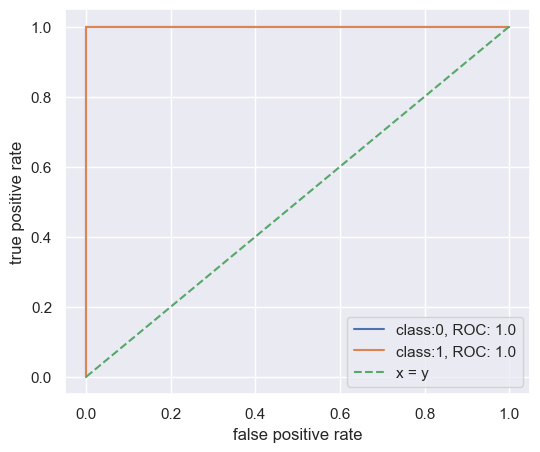

ROC for test:
[[15  0]
 [ 0  4]]


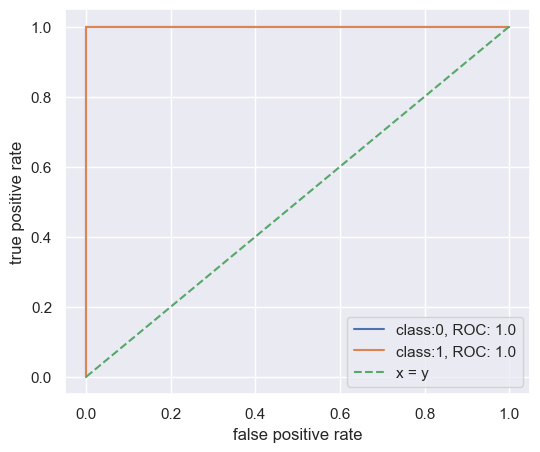

In [44]:
# after finding the bestL, performing Logistic Regression
kwargs = { 'penalty' : 'l1',  'max_iter' : 100,  'solver' : 'liblinear'}
performThisRegression(LogisticRegression, 'logistic regression (with L1)', bestL, kwargs, isBinary = True, wantROC=True)

### 2.(b)ii. Compare the L1-penalized with variable selection using p-values. 
Which one performs better? Which one is easier to implement?

L1-penalized logistic regression is used for feature selection without overfitting, on the other hand, p-values are useful to assess the statistical significance of the predictors. While using p-values for  selection can lead overfitting issues, L1-penalized regression can be robust when dealing with high-dimensional data and multicollinearity. 

Thanks to scientific literature and pre-made packages, both methods are easy to implement. In theory, p-value calculations are easier as it is more straightforward method, and L1-penalization method may require deeper understanding of optimization (more parameters).

### 2.(c) Multi-class Classification (The Realistic Case)

#### 2.(c)i. Find the best l in the same way as you found it in 2(b)i 
to build an L1-penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.

In [54]:
# reset globals
global maxAccuracy
global bestL
maxAccuracy = 0
bestL = 1

# set arguments for multi-class classification
kwargs = { 'penalty' : 'l1',  'max_iter' : 100, 'multi_class': 'multinomial', 'cv': 5, 'solver' : 'saga'}

# perform regression
for lVal in range(1, 21):
    performThisRegression(LogisticRegressionCV, 'logistic regression (multiclass)', lVal, kwargs, isBinary = False, wantROC = False)

Performing logistic regression (multiclass) for l = 1: training score is 1.0 (testing score is 0.8947)
Performing logistic regression (multiclass) for l = 2: training score is 1.0 (testing score is 0.9474)
Performing logistic regression (multiclass) for l = 3: training score is 1.0 (testing score is 0.8421)
Performing logistic regression (multiclass) for l = 4: training score is 1.0 (testing score is 0.8947)
Performing logistic regression (multiclass) for l = 5: training score is 1.0 (testing score is 0.8421)
Performing logistic regression (multiclass) for l = 6: training score is 1.0 (testing score is 0.7895)
Performing logistic regression (multiclass) for l = 7: training score is 1.0 (testing score is 0.7368)
Performing logistic regression (multiclass) for l = 8: training score is 1.0 (testing score is 0.7895)
Performing logistic regression (multiclass) for l = 9: training score is 0.9855 (testing score is 0.7895)
Performing logistic regression (multiclass) for l = 10: training score

Performing logistic regression (multiclass) for l = 2Confusion matrix:
[[2 0 0 0 0 0 0]
 [0 1 1 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]
ROC for Training


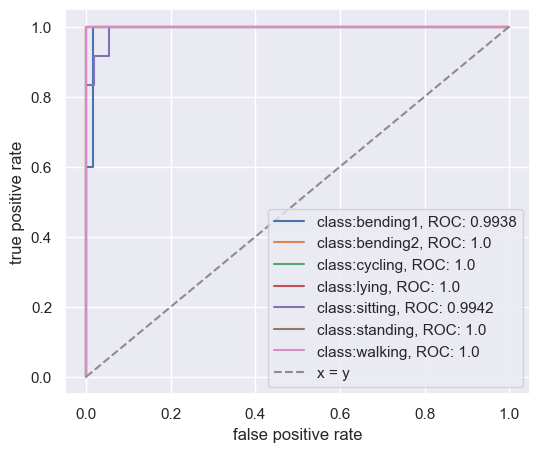

ROC for test:
[[2 0 0 0 0 0 0]
 [0 1 1 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]


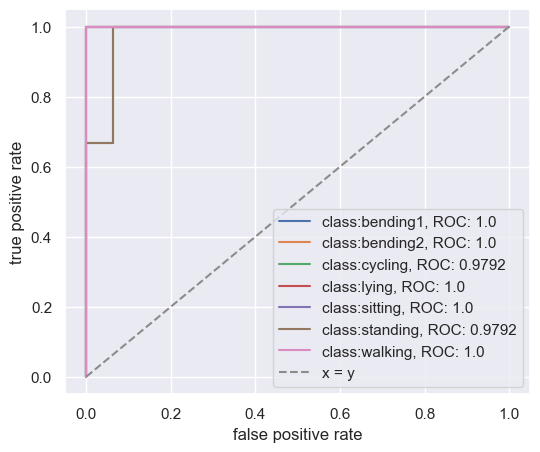

In [55]:
# after finding the bestL, performing Logistic Regression
kwargs = { 'penalty' : 'l1',  'max_iter' : 100,  'multi_class' : 'multinomial', 'solver' : 'saga'}
performThisRegression(LogisticRegression, 'logistic regression (multiclass)', bestL, kwargs, isBinary = False, wantROC = True)

#### 2.(c)ii. Repeat 2(c)i using a Na ̈ıve Bayes’ classifier. 
Use both Gaussian and Multinomial priors and compare the results.

In [57]:
# reset globals
global maxAccuracy
global bestL
maxAccuracy = 0
bestL = 1

# perform regression
for lVal in range(1, 21):
    performThisRegression(GaussianNB, 'naive Bayes classifier with Gaussian prior', lVal, {}, isBinary = False, wantROC = False)

Performing naive Bayes classifier with Gaussian prior for l = 1: training score is 1.0 (testing score is 0.8947)
Performing naive Bayes classifier with Gaussian prior for l = 2: training score is 1.0 (testing score is 0.6316)
Performing naive Bayes classifier with Gaussian prior for l = 3: training score is 0.9855 (testing score is 0.7368)
Performing naive Bayes classifier with Gaussian prior for l = 4: training score is 1.0 (testing score is 0.7895)
Performing naive Bayes classifier with Gaussian prior for l = 5: training score is 0.9855 (testing score is 0.7895)
Performing naive Bayes classifier with Gaussian prior for l = 6: training score is 0.971 (testing score is 0.6316)
Performing naive Bayes classifier with Gaussian prior for l = 7: training score is 1.0 (testing score is 0.7368)
Performing naive Bayes classifier with Gaussian prior for l = 8: training score is 0.9855 (testing score is 0.7368)
Performing naive Bayes classifier with Gaussian prior for l = 9: training score is 1.

Performing naive Bayes classifier with Gaussian prior for l = 1Confusion matrix:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 2 1 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]
ROC for Training


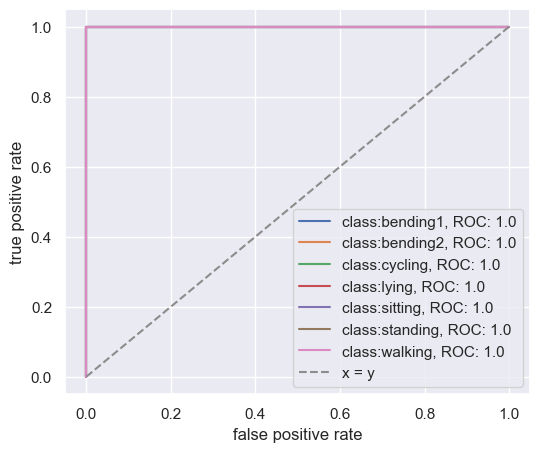

ROC for test:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 2 1 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]


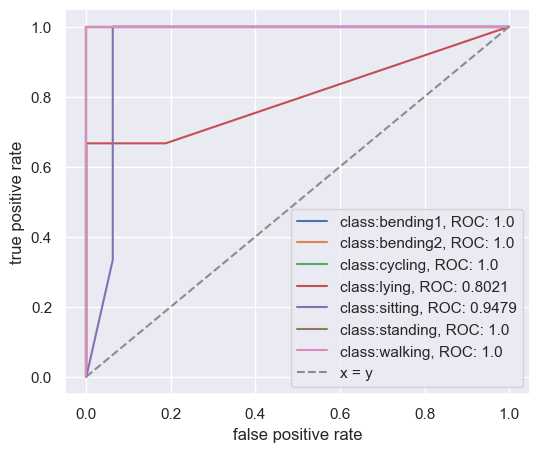

In [59]:
# after finding the bestL, performing  Regression
performThisRegression(GaussianNB, 'naive Bayes classifier with Gaussian prior', bestL, {}, isBinary = False, wantROC = True)

In [60]:
# reset globals
global maxAccuracy
global bestL
maxAccuracy = 0
bestL = 1

# perform regression
for lVal in range(1, 21):
    performThisRegression(MultinomialNB, 'naive Bayes classifier with Multinomial prior', lVal, {}, isBinary = False, wantROC = False)

Performing naive Bayes classifier with Multinomial prior for l = 1: training score is 0.9275 (testing score is 0.8947)
Performing naive Bayes classifier with Multinomial prior for l = 2: training score is 0.8841 (testing score is 0.7368)
Performing naive Bayes classifier with Multinomial prior for l = 3: training score is 0.8986 (testing score is 0.7895)
Performing naive Bayes classifier with Multinomial prior for l = 4: training score is 0.913 (testing score is 0.7895)
Performing naive Bayes classifier with Multinomial prior for l = 5: training score is 0.9275 (testing score is 0.7368)
Performing naive Bayes classifier with Multinomial prior for l = 6: training score is 0.9565 (testing score is 0.7368)
Performing naive Bayes classifier with Multinomial prior for l = 7: training score is 0.942 (testing score is 0.7368)
Performing naive Bayes classifier with Multinomial prior for l = 8: training score is 0.942 (testing score is 0.7368)
Performing naive Bayes classifier with Multinomial 

Performing naive Bayes classifier with Gaussian prior for l = 1Confusion matrix:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 2 1 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]
ROC for Training


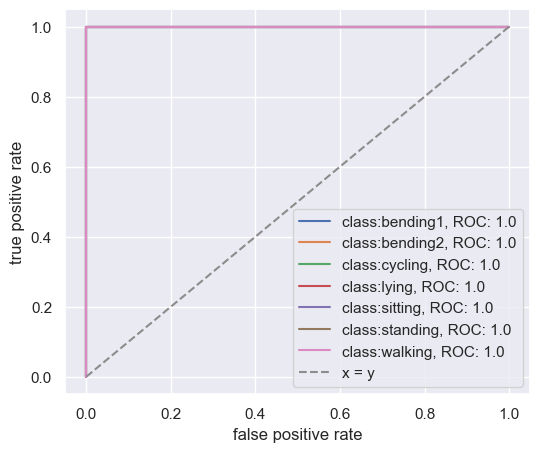

ROC for test:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 2 1 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]


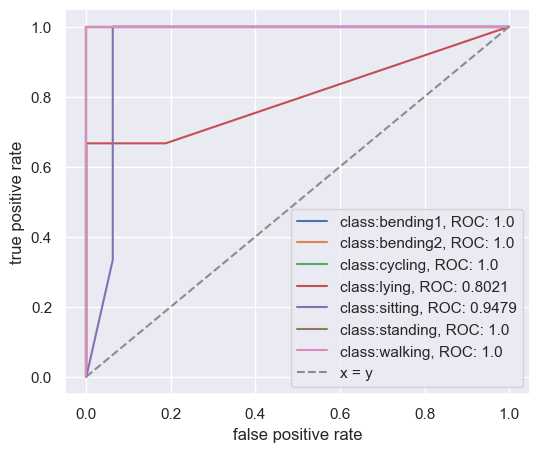

In [61]:
# after finding the bestL, performing  Regression
performThisRegression(GaussianNB, 'naive Bayes classifier with Gaussian prior', bestL, {}, isBinary = False, wantROC = True)

#### 2.(c)iii. Which method is better for multi-class classification in this problem? 

Gaussian Naive Bayes assumes that the features are conditionally independent. If the features are continuous and follow a normal distribution, this is optimal as independence assumption holds. Multinomial is mostly preferred when the features are discrete and the distribution of the features is multinomial. However, look at the area under the ROC curves, we can see that Logistic Regression performs better than any other classifer priors (Gaussian or Multinomial).

### 3. ISLR 4.8.3

![Answer ISLR 4.8.3](ISLR_483.jpg)

### 3. ISLR 4.8.7

![Answer ISLR 4.8.7](ISLR_487.jpg)